In [2]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense,Dropout,Flatten,Conv2D
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential

2022-10-08 18:17:06.682203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 18:17:07.072552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rishi/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-08 18:17:07.072594: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-08 18:17:07.132223: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

In [3]:
TRAIN_DIR='/home/rishi/Desktop/MachineLearning/Facial_Recognition/Training'
TEST_DIR='/home/rishi/Desktop/MachineLearning/Facial_Recognition/Testing'

In [4]:
def load_data(dir_path,IMG_SIZE):
    X=[]
    Y=[]
    i=0
    labels=dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i]=path
            for file in os.listdir(dir_path+'/'+path):
                if not file.startswith('.'):
                    img=cv.imread(dir_path+'/'+path+'/'+file)
                    img=img.astype('float32')/255
                    resized=cv.resize(img,IMG_SIZE,interpolation = cv.INTER_AREA)
                    X.append(resized)
                    Y.append(i)
            i+=1
    
    X=np.array(X)
    Y=np.array(Y)
    print(f'{len(X)} images loaded from {dir_path}')
    return X,Y,labels
                    

In [5]:
IMG_SIZE=(48,48)

In [6]:
X_train,Y_train,train_labels=load_data(TRAIN_DIR,IMG_SIZE)

100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.00it/s]


28273 images loaded from /home/rishi/Desktop/MachineLearning/Facial_Recognition/Training


In [7]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [8]:
X_test,y_test,test_labels=load_data(TEST_DIR,IMG_SIZE)
print(y_test)

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.25it/s]


7067 images loaded from /home/rishi/Desktop/MachineLearning/Facial_Recognition/Testing
[0 0 0 ... 5 5 5]


In [9]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

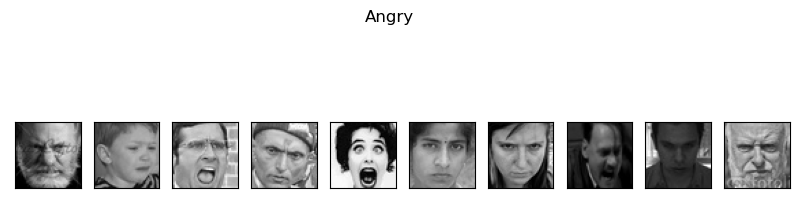

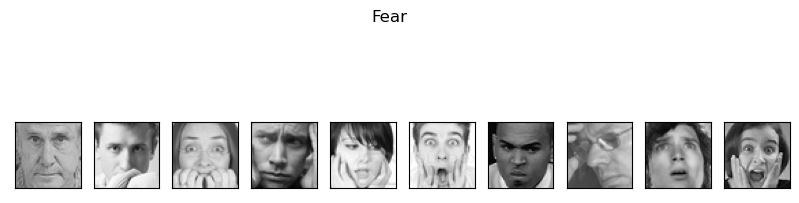

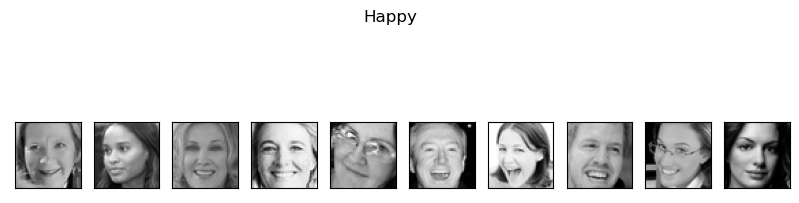

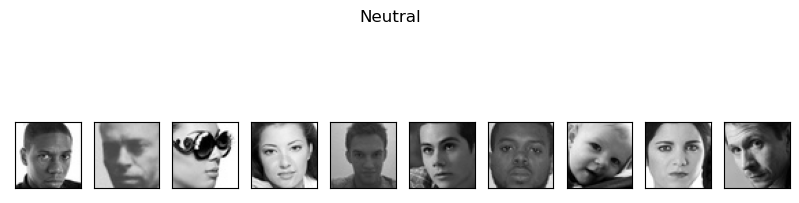

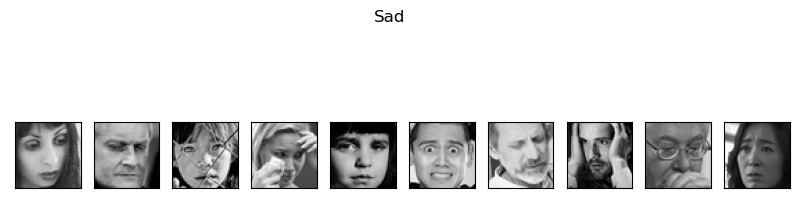

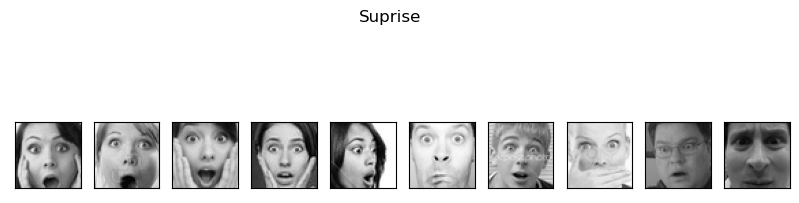

In [10]:
plot_samples(X_train,Y_train,train_labels,10)

In [11]:
from keras.utils.np_utils import to_categorical
Y_train=to_categorical(Y_train,num_classes=6)
Y_train.shape

(28273, 6)

In [12]:
Y_test=to_categorical(y_test,num_classes=6)
Y_test.shape
y_test.shape

(7067,)

In [14]:
from keras.applications.vgg16 import VGG16

base_model=VGG16(
weights=None,
include_top=False,
input_shape=IMG_SIZE+(3,)
)

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [15]:
model=Sequential([
    base_model,
    Flatten(),
    Dense(units=1000,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dropout(0.4),
    Dense(6,activation='softmax')
])

In [16]:
from keras.optimizers import RMSprop,Adam
model.compile(
loss='binary_crossentropy',
optimizer=RMSprop(learning_rate=1e-4),
metrics=['accuracy'])

In [33]:
history=model.fit(X_train,Y_train,epochs=1,batch_size=64)

442/442 [==============================] - 1270s 3s/step - loss: 1.5423 - accuracy: 0.2466


In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

221/221 [==============================] - 33s 149ms/step
Test Accuracy =0.17


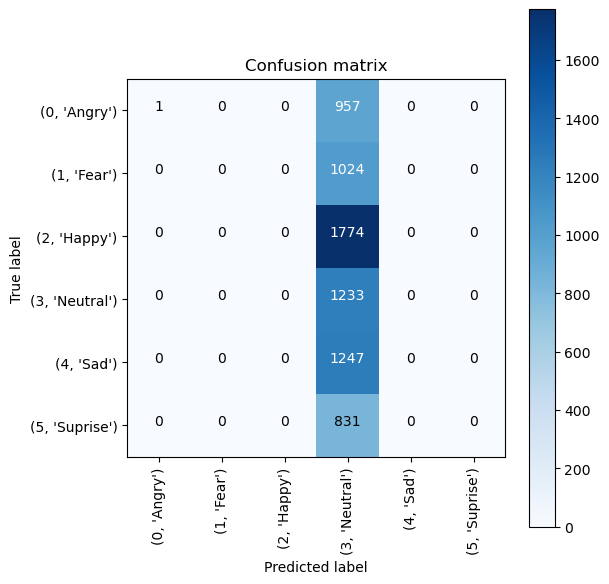

In [22]:
from sklearn.metrics import accuracy_score,confusion_matrix
#Validations on test set
predictions=model.predict(X_test)
y_pred=[np.argmax(probas) for probas in predictions]

accuracy=accuracy_score(y_test,y_pred)
print('Test Accuracy =%.2f' % accuracy)
confusion_mtx=confusion_matrix(y_test,y_pred)
cm=plot_confusion_matrix(confusion_mtx,classes=list(test_labels.items()),normalize=False)

In [24]:
batch_size=64
from keras.preprocessing.image import ImageDataGenerator
datagen_test=ImageDataGenerator(rescale=1./255)
pred_generator=datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [25]:
new_predictions=model.predict(X_test)
y_pred=[np.argmax(probas) for probas in new_predictions]
y_pred=[test_labels[k] for k in y_pred]

221/221 [==============================] - 33s 147ms/step


In [26]:
filenames=pred_generator.filenames
actual_class=[test_labels[h] for h in pred_generator.classes]

In [27]:
import pandas as pd
pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Neutral,Angry
1,Angry/Angry-10.jpg,Neutral,Angry
2,Angry/Angry-100.jpg,Neutral,Angry
3,Angry/Angry-101.jpg,Neutral,Angry
4,Angry/Angry-102.jpg,Neutral,Angry


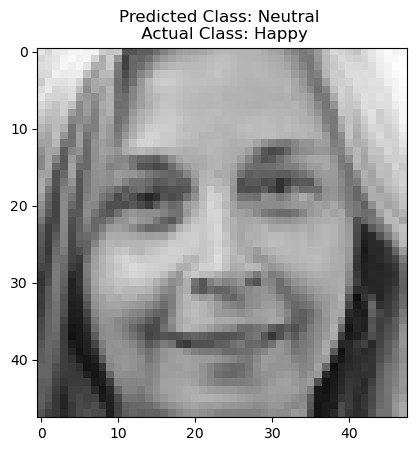

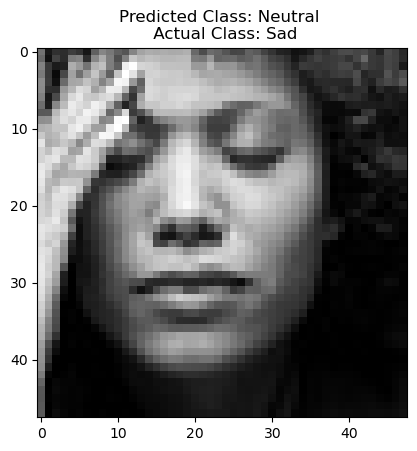

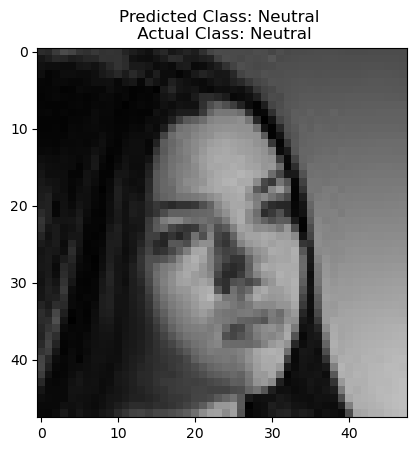

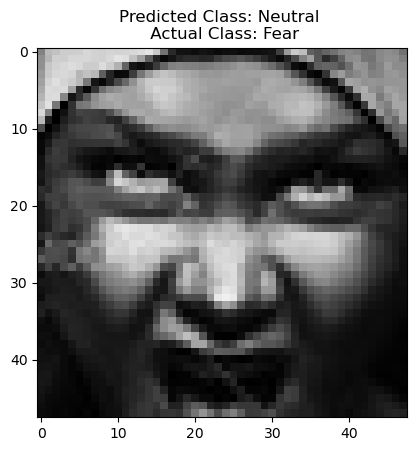

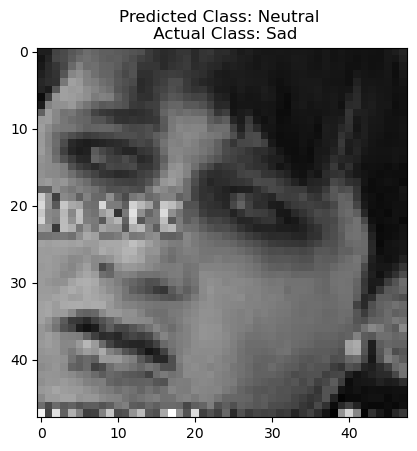

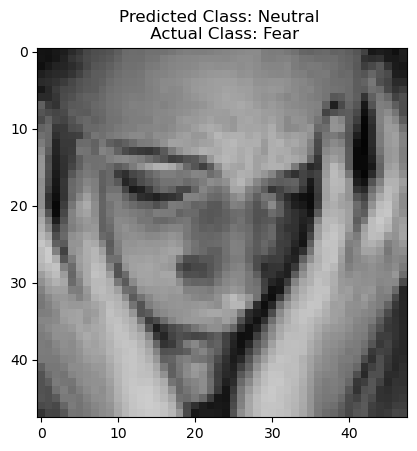

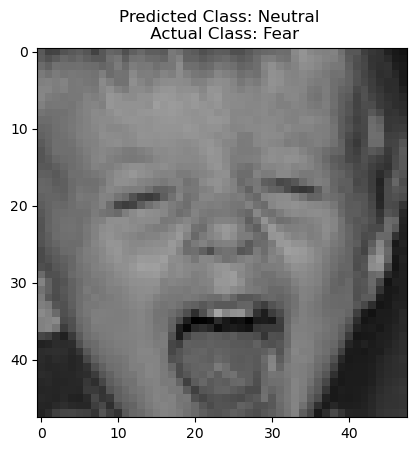

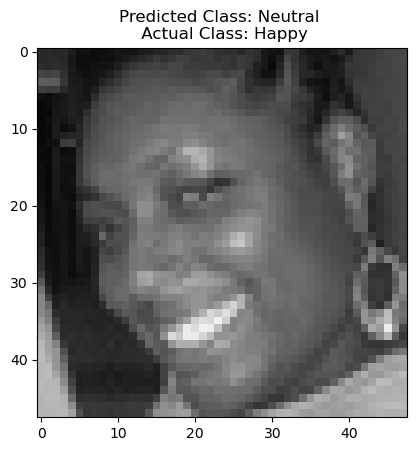

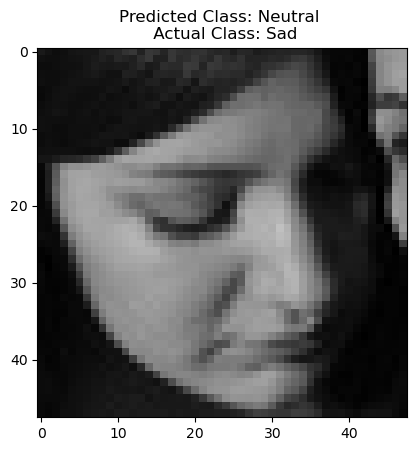

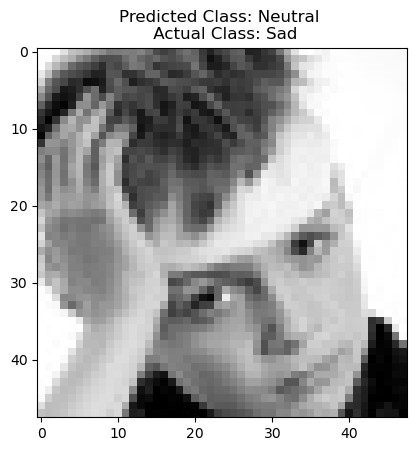

In [29]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv.imread(img_path)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass